# Проект 3
# Определение перспективного тарифа для телеком-компании

Федеральному оператору связи "Мегалайн" нужно скорректировать рекламный бюджет, и поэтому коммерческий департамент поставил задачу выяснить, какой из двух тарифов приносит больше денег компании.

На рассмотрении два тарифа - "Смарт" и "Ультра"

||Смарт|Ультра|
|:-|:-:|:-:|
|Пакет|||
|Минут|500|3000|
|Сообщений|50|1000|
|Интернет|15|30|
| | | |
|Сверх пакета|||
|Минута|3|1|
|Сообщение|3|1|
|Гб|200|150|
| | | |
|Плата|550|1950|

В нашем распоряжении небольшая выборка из данных 500 пользователей за 2018 год: кто, откуда, каким тарифом пользуются, сколько совершают звонков и отправляют сообщений в день. Нужно проанализировать клиентов и выяснить, какой тариф должен быть приоритетнее.



## Структура проекта
1. [Начало работы](#start)
2. [Предобработка данных](#preprocessing)
3. [Анализ данных](#analisys)
4. [Проверка гипотез](#hypothesis)
5. [Выводы](#conclusions)

## Начало работы
<a id='start'></a>
<a name='start'></a>

Для начала импортируем необходимые библиотеки:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

DATE_FORMAT = '%Y-%m-%d'

Загрузим необходимые датасеты:

In [4]:
calls = pd.read_csv('datasets/calls.csv')
internet = pd.read_csv('datasets/internet.csv')
messages = pd.read_csv('datasets/messages.csv')
tariffs = pd.read_csv('datasets/tariffs.csv')
users = pd.read_csv('datasets/users.csv')

Проведём первичный осмотр данных, чтобы составить дальнейший план действий, и сразу же сделаем базовые необходимые операции (вроде преобразования даты и округления чисел).

Начём по порядку - *Calls*:

In [5]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


Из сопроводительной информации узнаём о значении каждого поля:
    <details>
- *id* — уникальный номер звонка
- *call_date* — дата звонка
- *duration* — длительность звонка в минутах
- *user_id* — идентификатор пользователя, сделавшего звонок
    </details>

Взглянем и на сами данные:

In [6]:
np.random.seed(42)
calls.sample(10)

,id,call_date,duration,user_id
158741,1392_406,2018-07-09,4.94,1392
95947,1244_202,2018-11-09,0.00,1244
10624,1027_494,2018-10-07,3.10,1027
167423,1412_340,2018-09-25,5.91,1412
73194,1184_168,2018-09-03,9.86,1184
176140,1435_58,2018-12-21,2.31,1435
41601,1102_28,2018-09-21,2.44,1102
124173,1319_322,2018-12-28,16.24,1319
19027,1052_176,2018-11-11,15.55,1052
188175,1464_695,2018-09-01,0.00,1464


In [7]:
def sample(df):
    return df.sample(10, random_state=42)

Поле *id* нам не нужно для дальнейшей работы (его можно было бы сократить до цифр после _ (первая часть дублирует user_id) и сделать целочисленным, или ещё лучше просто заполнить целыми числами от 0 до len(calls), так как там могут сбрасываться счётчики для каждого клиента), а вот поле *duration* стоит округлить вверх и сделать целочисленным, а поле *call_date* сделать датой.



---



Далее - *internet*:

In [8]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


Из сопроводительной информации узнаем о значении каждого поля:
    <details>
- *id* — уникальный номер сессии
- *mb_used* — объём потраченного за сессию интернет-трафика (в мегабайтах)
- *session_date* — дата интернет-сессии
- *user_id* — идентификатор пользователя
    </details>

Сразу удалим столбец *Unnamed: 0*, который возник из-за ошибки выгрузки (скорее всего, потому что он дублирует индексы), и взглянем на сами данные:

In [9]:
internet = internet.drop(internet.columns[0], axis=1)
sample(internet)

,id,mb_used,session_date,user_id
31737,1110_331,351.71,2018-09-04,1110
31333,1109_399,257.69,2018-06-09,1109
61121,1207_191,128.18,2018-11-05,1207
71184,1241_88,736.71,2018-11-23,1241
84394,1286_76,900.69,2018-12-18,1286
146984,1491_256,464.64,2018-07-31,1491
32352,1113_196,72.39,2018-11-04,1113
103524,1349_40,779.95,2018-12-23,1349
26570,1092_236,229.27,2018-11-17,1092
9728,1033_108,457.25,2018-08-11,1033


Тут такая же история - нужно округлить количество мегабайт вверх и поменять тип данных поля с датой, так же добавим столбец с потраченными Гб.



---



*messages*:

In [10]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Узнаём про кадое поле:
 <details>
- *id* — уникальный номер сообщения  
- *message_date* — дата сообщения  
- *user_id* — идентификатор пользователя, отправившего сообщение  
</details>

In [11]:
sample(messages)

,id,message_date,user_id
8581,1033_332,2018-11-08,1033
12476,1054_32,2018-08-10,1054
14805,1065_141,2018-05-29,1065
118278,1481_49,2018-05-24,1481
23803,1099_10,2018-08-24,1099
93256,1383_7,2018-11-04,1383
81126,1340_100,2018-07-01,1340
41780,1178_3,2018-06-09,1178
73875,1311_284,2018-10-03,1311
118967,1482_529,2018-09-24,1482


Так же нужно будет преобразовать поле даты.



---



*tariffs*:

In [12]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [13]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Информация о каждом поле:
 <details>
- *tariff_name* — название тарифа
- *rub_monthly_fee* — ежемесячная абонентская плата в рублях
- *minutes_included* — количество минут разговора в месяц, включённых в абонентскую плату
- *messages_included* — количество сообщений в месяц, включённых в абонентскую плату
- *mb_per_month_included* — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- *rub_per_minute* — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- *rub_per_message* — стоимость отправки сообщения сверх тарифного пакета
- *rub_per_gb* — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)
 </details>

Нужно будет пересчитать включённые в пакет МБ в ГБ и поменять названия столбцов для удобства.



---



И, наконец, таблица *users*:

In [14]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [15]:
sample(users)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
361,1361,38,NaN,Екатеринбург,Рената,Кошелева,2018-09-09,ultra
73,1073,63,NaN,Владикавказ,Гордей,Павловский,2018-10-04,smart
374,1374,67,NaN,Махачкала,Леонид,Аркадьев,2018-04-01,smart
155,1155,71,NaN,Ставрополь,Александр,Чернов,2018-01-02,smart
104,1104,60,NaN,Нижний Тагил,Габриэль,Поляков,2018-02-21,ultra
394,1394,47,NaN,Орёл,Ксения,Жукова,2018-01-12,smart
377,1377,59,NaN,Брянск,Альфред,Семин,2018-02-25,ultra
124,1124,54,NaN,Махачкала,Альбин,Андрианов,2018-09-24,ultra
68,1068,34,NaN,Москва,Ким,Демьянов,2018-07-16,smart
450,1450,53,NaN,Москва,Алиса,Козлова,2018-10-10,smart


Значения полей:
 <details>
- *user_id* — уникальный идентификатор пользователя
- *first_name* — имя пользователя
- *last_name* — фамилия пользователя
- *age* — возраст пользователя (годы)
- *reg_date* — дата подключения тарифа (день, месяц, год)
- *churn_date* — дата прекращения пользования тарифом (если значение пропущено, то - тариф ещё действовал на момент выгрузки данных)
- *city* — город проживания пользователя
- *tariff* — название тарифного плана
</details>

Так же нужно обработать поля с датой, плюс сделаем для удобства поле *user_id* индексом.



---



Напишем цикл для преобразования полей с датой в формат даты:

In [16]:
for df in [calls, internet, messages, users]:
    for col in df:
        if not col.endswith('_date'): continue

        df[col] = pd.to_datetime(df[col], 
                                 format=DATE_FORMAT, 
                                 errors='coerce')

Сделаем оставшиеся необходимые преобразования:

In [17]:
calls['duration'] = np.ceil(calls['duration']).astype('int')
internet['gb_used'] = np.ceil(internet['mb_used']) / 1024
tariffs['mb_per_month_included'] = (tariffs['mb_per_month_included'] / 1024).astype('int')

users.index = users['user_id']
tariffs.columns = ['msg_included', 
                   'gb_included', 
                   'min_included', 
                   'price', 
                   'rub_gb', 
                   'rub_msg', 
                   'rub_min', 
                   'tariff',
                   ]



---



## Предобработка данных
<a name='preprocessing'></a>
<a id='preprocessing'></a>

Начнём с проверки грубых дубликатов:

In [18]:
for df in [messages, calls, internet]:
    print(df[['id']].duplicated().sum())

users.index.duplicated().sum()

0
0
0


0

Проверим данные на ошибки:

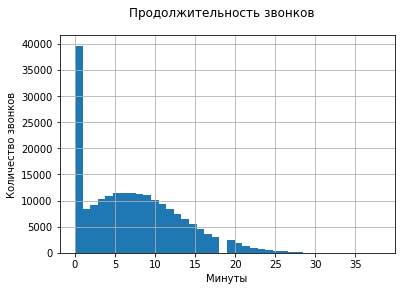

In [19]:
calls['duration'].hist(bins=40)
plt.suptitle('Продолжительность звонков')
plt.ylabel('Количество звонков')
plt.xlabel('Минуты')
plt.show()

Распределение похоже на ожилаемое распределение Пуассона (пик на 0 минут объясняется, скорее всего, неотвеченными звонками)

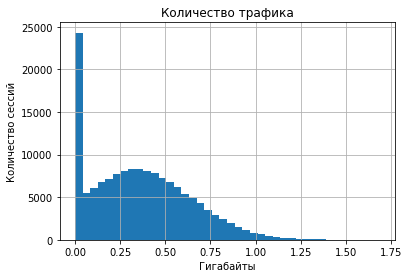

In [20]:
internet['gb_used'].hist(bins=40)
plt.title('Количество трафика')
plt.ylabel('Количество сессий')
plt.xlabel('Гигабайты')
plt.show()

Здесь тоже распределение похоже на ожидаемое, а нулевой трафик, скорее всего, означает отсутствие трафика у человека в этот день.

Проверим ошибки в поле *user_id* каждой таблицы:

In [21]:
ids = [i for i in range(1000, 1500)]
for df in [calls, internet, messages]:
    print(
        df.loc[~df['user_id'].isin(ids), 'user_id'].count()
    )
print(users.loc[~users.index.isin(ids), 'age'].count())

0
0
0
0


Серьёзных ошибок в нужных полях, на первый взгляд, нет. Исправим их, если что-то появится, а пока создадим новый столбец с номером месяца в таблицах *calls, internet, messages*:

In [22]:
for df in [calls, internet, messages]:
    column = df.select_dtypes('datetime').columns[0]
    df['month'] = df[column].dt.month

Сагрегируем таблицы *calls, messages, internet* по пользователям, посчитав сумму потраченых минут, сообщений и мегабайтов в каждом месяце, объединив всё это в одну таблицу и добавив столбец с тарифом И городом для дальнейших рассчётов:

In [23]:
df = (calls.groupby(['user_id', 'month'])['duration'].agg(('sum', 'count'))
.join(internet.groupby(['user_id', 'month'])['gb_used'].agg('sum'), how='outer')
.join(messages.groupby(['user_id', 'month'])['id'].agg('count'), how='outer')
.join(users[['tariff', 'city']]))
df.columns = ['min', 'count_calls', 'gb', 'msg', 'tariff', 'city']

Образовавшиеся пропуски заполним нулями (человек в определённом месяце не пользовался смс или интернетом, например, но тариф всё равно оплачивал) и приведём все столбцы к типу *int*, предварительно округлив количество ГБ вверх:

In [24]:
df['gb'] = np.ceil(df['gb'])
df = df.fillna(0).astype('int', errors='ignore')
df.dtypes

min             int64
count_calls     int64
gb              int64
msg             int64
tariff         object
city           object
dtype: object

Для удобства создадим словарь с названиями тарифов и заменим их в *df* на их *id*:

In [25]:
dict_tariffs = tariffs['tariff'].to_dict()
df['tariff'] = df['tariff'].replace({v: k for k, v in dict_tariffs.items()})

~Так же поступим с названиями городов:~

In [26]:
# # %%time
# dict_city = pd.Series(users['city'].unique()).to_dict()
# df['city'] = df['city'].replace({v: k for k, v in dict_city.items()})

In [27]:
df.head()

min  count_calls  gb  msg  tariff       city
user_id month                                              
1000    5      159           22   3   22       1  Краснодар
        6      172           43  23   60       1  Краснодар
        7      340           47  14   75       1  Краснодар
        8      408           52  14   81       1  Краснодар
        9      466           58  15   57       1  Краснодар

<font color='blue'>
    выше просто разбираюсь со словарями, тут они излишни, на самом деле

Напишем функцию для нахождения стоимости каждого месяца пользования тарифом для каждого пользователя:

In [28]:
def payment(row):
    tariff = row['tariff']
    price = tariffs.loc[tariff, 'price']
    
    for pack in ['min', 'msg', 'gb']:
        over_pack = row[pack] - tariffs.loc[tariff, f'{pack}_included']
        price += max(over_pack, 0) * tariffs.loc[tariff, f'rub_{pack}']
    
    return price

И создадим поле *payment* с этой суммой:

In [29]:
df['payment'] = df.apply(payment, axis=1)

Сбросим индекс для дальнейшего удобства:

In [30]:
df = df.reset_index()
df

,user_id,month,min,count_calls,gb,msg,tariff,city,payment
0,1000,5,159,22,3,22,1,Краснодар,1950
1,1000,6,172,43,23,60,1,Краснодар,1950
2,1000,7,340,47,14,75,1,Краснодар,1950
3,1000,8,408,52,14,81,1,Краснодар,1950
4,1000,9,466,58,15,57,1,Краснодар,1950
...,...,...,...,...,...,...,...,...,...
3209,1498,10,247,41,21,42,0,Владикавказ,1750
3210,1499,9,70,9,2,11,0,Пермь,550
3211,1499,10,449,68,18,48,0,Пермь,1150
3212,1499,11,612,74,18,59,0,Пермь,1513




---



## Анализ данных
<a id='analisys'></a>
<a name='analisys'></a>

Для для обоснованного выбора тарифа нужно проанализировать, как пользователи их используют. 

Для начала посмотрим, как часто пользователи выходят за границы своего тарифа:

In [49]:
for tariff in tariffs.index:
    mean = (df[df['tariff'] == tariff]['payment'] > 
     tariffs.loc[tariff, 'price']).mean()

    print(tariffs.loc[tariff, 'tariff'], mean)

smart 0.746971736204576
ultra 0.13604060913705585


Как видно, пользователи с тарифом smart намного активнее покупают дополнительные пакеты к своему тарифу, нежели пользователи с тарифом ultra. 

Посмотрим, какие пакеты покупаются чаще всего:

In [32]:
# %%time
mean_buy ={}
count_buy = {}

for pack in ['min', 'msg', 'gb']:
    mean_buy[pack] = []
    count_buy[pack] = []
    for tariff in tariffs.index:
        series = (df.query('tariff == @tariff')[pack] > 
                tariffs.loc[tariff, f'{pack}_included'])
        mean_buy[pack].append(series.mean())
        count_buy[pack].append(series.sum())

mean_buy = pd.DataFrame(mean_buy).T
count_buy = pd.DataFrame(count_buy).T

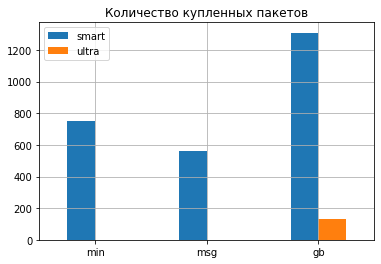

In [48]:
count_buy.plot(kind='bar', 
              title='Количество купленных пакетов', 
              grid=True)

plt.legend(labels=('smart', 'ultra'))
plt.xticks(rotation=0)
plt.show()

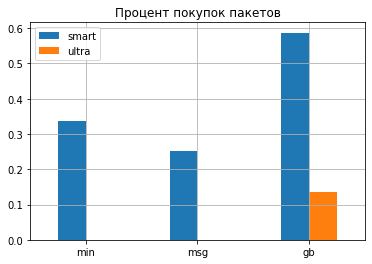

In [34]:
mean_buy.plot(kind='bar', 
              title='Процент покупок пакетов', 
              grid=True)

plt.legend(labels=('smart', 'ultra'))
plt.xticks(rotation=0)
plt.show()

Как видно, пользователи покупают чаще всего (а на тарифе ultra и вообще только их) пакеты дополнительного трафика.

Взглянем дополнительно на процент использования включенного количества минут, сообщений и гигабайт:

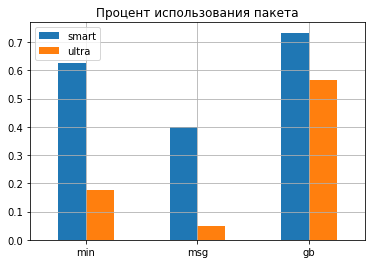

In [35]:
piece_pack ={}

for pack in ['min', 'msg', 'gb']:
    piece_pack[pack] = []
    for tariff in tariffs.index:
        inpack = tariffs.loc[tariff, f'{pack}_included']
        
        piece = (df.loc[(df['tariff'] == tariff)&
                        (df[pack] <= inpack), pack] / inpack).mean()
        
        piece_pack[pack].append(piece)

pd.DataFrame(piece_pack).T.plot(kind='bar', 
                                title='Процент использования пакета', 
                                grid=True)
plt.legend(labels=('smart', 'ultra'))
plt.xticks(rotation=0)
plt.show()

Из этого графика видно, что пользователи тарифа ultra, которые не покупают доп пакеты, почти совсем не тратят пакеты минут и сообщений, а пакет трафика тратят чуть больше чем наполовину, тогда как пользователи с тарифом smart используют свои пакеты намного активней.

Возможно, подобная переплата за невостребованные лимиты может вызвать отток пользователей с тарифа ultra. Попробуем это проверить:

In [36]:
users.loc[(users['tariff'] == 'ultra')&(~users['churn_date'].isna())].index

Int64Index([1019, 1050, 1063, 1090, 1128, 1201, 1254, 1255, 1265, 1271, 1343,
            1367, 1392, 1399, 1416],
           dtype='int64', name='user_id')

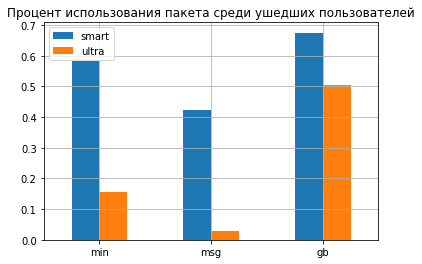

In [37]:
churn_users = users.loc[~users['churn_date'].isna()].index

piece_pack ={}

for pack in ['min', 'msg', 'gb']:
    piece_pack[pack] = []
    for tariff in tariffs.index:
        inpack = tariffs.loc[tariff, f'{pack}_included']
        
        piece = (df.loc[(df['tariff'] == tariff)&
                        (df[pack] <= inpack)&
                        (df['user_id'].isin(churn_users)), pack] / inpack).mean()
        
        piece_pack[pack].append(piece)

pd.DataFrame(piece_pack).T.plot(kind='bar', 
                                title='Процент использования пакета среди ушедших пользователей', 
                                grid=True)
plt.legend(labels=('smart', 'ultra'))
plt.xticks(rotation=0)
plt.show()

Выборка крайне малая и поэтому совсем не репрезентативная, поэтому какие-либо выводы делать по этому графику нельзя, но можно выдвинуть гипотезу для будущих исследований (когда наберётся достаточно данных):

>Пользователи дорогих тарифов, тратящие лишь малую часть своих пакетов, переходят на более дешёвые тарифы, в то время как пользователи дешёвых тарифов, тратящие большую часть своих пакетов, переходят на более дорогие

В пользу этого могут говорить уменьшение части использования пакетов пользователей с тарифом ultra и увеличение у пользователей с тарифом smart.

Посмотрим, наконец, на суммарные выручки по этим двум тарифам:

(array([0, 1]), <a list of 2 Text xticklabel objects>)

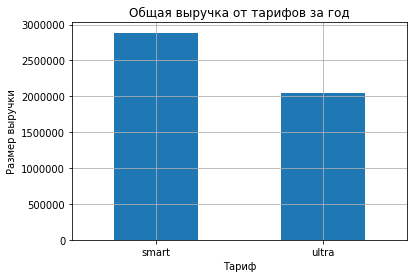

In [38]:
# df.pivot_table(index='tariff', values='payment', aggfunc='sum')
(df.replace({'tariff': dict_tariffs})
   .groupby('tariff')['payment']
   .sum()
   .plot(kind='bar', title='Общая выручка от тарифов за год', grid=True))

plt.ylabel('Размер выручки')
plt.xlabel('Тариф')
plt.xticks(rotation=0)

Годовая выручка по тарифам так же отличается почти на миллион в пользу тарифа smart и пока что всё говорит о выборе именно этого тарифа.

In [39]:
# df['overpay'] = df[['tariff', 'payment']].apply(
#     lambda x: x['payment'] - tariffs.loc[x['tariff'], 'price'], axis=1)

# overpays = df.pivot_table(
#     index=['user_id'], values='overpay', aggfunc='sum'
#     ).sort_values(by='overpay', ascending=False).head(100).index

# users.loc[overpays, 'tariff'].value_counts(normalize=True)

~Тут я пытался посмотреть кто тратит больше всех деленег для выявления ЦА для выводов, но что-то не увидел ничего путного~



Для окончательного решения нужно проверить гипотезы.



---



## Проверка гипотез
<a id='hypothesis'></a>
<a name='hypothesis'></a>

Убедимся в правильности нашего выбора, сравнив среднюю выручку за месяц по каждому тарифу между собой:

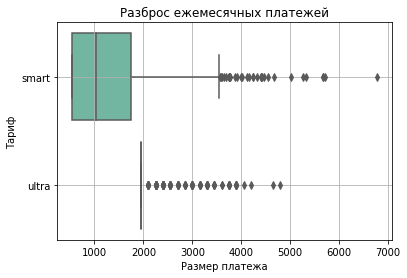

In [40]:
sns.boxplot(
    data=(df.query('tariff == 0')['payment'], 
          df.query('tariff == 1')['payment']), 
    orient="h", 
    palette="Set2")

plt.grid()
plt.title("Разброс ежемесячных платежей")
plt.yticks(ticks=[0, 1], labels=['smart', 'ultra'])
plt.xlabel('Размер платежа')
plt.ylabel('Тариф')

plt.show()

Взглянем дополнительно на `describe()`:

In [41]:
df.query('tariff == 0')['payment'].describe().to_frame().join(
    df.query('tariff == 1')['payment'].describe(),
    lsuffix='_smart',
    rsuffix='_ultra')

,payment_smart,payment_ultra
count,2229.000000,985.000000
mean,1294.639300,2071.065990
std,820.933202,378.802377
min,550.000000,1950.000000
25%,550.000000,1950.000000
50%,1038.000000,1950.000000
75%,1750.000000,1950.000000
max,6770.000000,4800.000000


Проверим, можно ли вообще считать все эти отличия значимыми.

- $H_0$ - средние равны
- $H_1$ - средние отличаются

Используем критерий Стьюдента для проверки гипотезы о равенстве двух средних.

*equal_var* передадим *False*, так как стандартное отклонение отличается очень сильно, доверительный интервал примем как стандартные 5%:

In [42]:
pval = scipy.stats.ttest_ind(df.query('tariff == 0')['payment'],
                      df.query('tariff == 1')['payment'],
                      equal_var=False).pvalue

pval < 0.05

True

У нас есть все основания отклонить нулевую гипотезу. Следовательно, мы можем сделать вывод, что различия между тарифами существенны.

Взглянем на выборку только по столице, и сравним её со всей страной.
- $H_0$ - средние равны
- $H_1$ - средние отличаются

На всякий случай проверим дополнительно размер выборки по столице:

In [43]:
df.query('city == "Москва"')['payment'].count()

611

611 записей достаточно для критерия Стьюдента.

In [44]:
pval = scipy.stats.ttest_ind(df.query('city == "Москва"')['payment'],
                      df.query('city != "Москва"')['payment'],
                      equal_var=False).pvalue

pval < 0.05

False

У нас нет оснований отклонять нулевую гипотезу, следовательно, можно утверждать, что выручка по Москве не отличается от средней выручки по России.

Сравним выборки по Москве и Питеру

In [45]:
df.query('city == "Санкт-Петербург"')['payment'].count()

270

In [46]:
pval = scipy.stats.ttest_ind(df.query('city == "Москва"')['payment'],
                      df.query('city == "Санкт-Петербург"')['payment'],
                      equal_var=False).pvalue

pval < 0.05

False

В данном случае выборки тоже не отличаются друг от друга.



---



## Выводы
<a id='conclusions'></a>
<a name='conclusions'></a>

Проведя анализ выборки из 500 пользователей и подкрепив выводы с помощью проверки гипотезы о равенстве средних, мы с полной уверенностью можем сделать вывод, что наиболее востребованным тарифом является тариф smart.

- у него больше пользователей (у 70% пользователей тариф smart)
- у него больше выручка за год (3 миллиона против 2)
- его пользователи намного чаще покупают дополнительные пакеты минут, трафика и сообщений(74% пользователей против 12%), из-за чего платят намного больше стандартной цены тарифа(среди 100 самых переплативших пользователей 96% - с тарифом smart), что позволит при правильной рекламе зарабатывать ещё больше

